In [1]:
# 데이터를 다운로드 받습니다.

!wget https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_x_train.csv
!wget https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_y_train.csv
!wget https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_x_test.csv
!wget https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_y_test.csv

--2022-02-22 10:23:31--  https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_x_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12044 (12K) [text/plain]
Saving to: ‘1977_x_train.csv’

1977_x_train.csv    100%[===================>]  11.76K  --.-KB/s    in 0s      

2022-02-22 10:23:31 (52.0 MB/s) - ‘1977_x_train.csv’ saved [12044/12044]

--2022-02-22 10:23:31--  https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_y_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4675 (4

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

## First, load the data and apply preprocessing


In [3]:
df_x = pd.read_csv("1977_x_train.csv")
df_y = pd.read_csv("1977_y_train.csv")
df = pd.concat([df_x, df_y], axis=1)

First, need to perform some preprocessing to encode users and movies as integer indices.


In [4]:
user_ids = df["userid"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
task_ids = df["taskid"].unique().tolist()
task2task_encoded = {x: i for i, x in enumerate(task_ids)}
task_encoded2task = {i: x for i, x in enumerate(task_ids)}
df["user"] = df["userid"].map(user2user_encoded)
df["task"] = df["taskid"].map(task2task_encoded)

num_users = len(user2user_encoded)
num_task = len(task_encoded2task)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
MIN_RATING = 0.5
MAX_RATING = 5.0

print(
    "Number of users: {}, Number of task: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_task, MIN_RATING, MAX_RATING
    )
)

Number of users: 13, Number of task: 102, Min rating: 0.5, Max rating: 5.0


## Prepare training and validation data


In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "task"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - MIN_RATING) / (MAX_RATING - MIN_RATING)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [6]:
EMBEDDING_SIZE = 128

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_task, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_task = num_task
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.task_embedding = layers.Embedding(
            num_task,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.task_bias = layers.Embedding(num_task, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        task_vector = self.task_embedding(inputs[:, 1])
        task_bias = self.task_bias(inputs[:, 1])
        dot_user_task = tf.tensordot(user_vector, task_vector, 2)
        # Add all the components (including bias)
        x = dot_user_task + user_bias + task_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_task, EMBEDDING_SIZE)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.MeanSquaredError()])


## Train the model based on the data split


In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=300,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/300
132/132 [==============================] - 3s 7ms/step - loss: 0.3399 - mean_squared_error: 0.3394 - val_loss: 0.3870 - val_mean_squared_error: 0.3865
Epoch 2/300
132/132 [==============================] - 0s 3ms/step - loss: 0.2881 - mean_squared_error: 0.2876 - val_loss: 0.3770 - val_mean_squared_error: 0.3765
Epoch 3/300
132/132 [==============================] - 1s 5ms/step - loss: 0.2816 - mean_squared_error: 0.2811 - val_loss: 0.3678 - val_mean_squared_error: 0.3673
Epoch 4/300
132/132 [==============================] - 1s 4ms/step - loss: 0.2751 - mean_squared_error: 0.2746 - val_loss: 0.3600 - val_mean_squared_error: 0.3595
Epoch 5/300
132/132 [==============================] - 0s 4ms/step - loss: 0.2678 - mean_squared_error: 0.2673 - val_loss: 0.3522 - val_mean_squared_error: 0.3517
Epoch 6/300
132/132 [==============================] - 0s 3ms/step - loss: 0.2510 - mean_squared_error: 0.2505 - val_loss: 0.3643 - val_mean_squared_error: 0.3638
Epoch 7/300
132/132 [=

## Plot training and validation loss


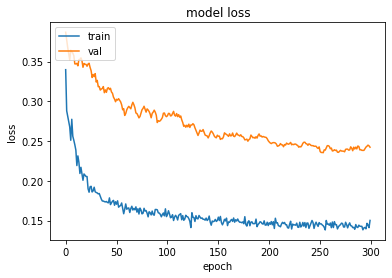

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [9]:
df_x_test = pd.read_csv('1977_x_test.csv')

In [10]:
df_x_test["user"] = df_x_test["userid"].map(user2user_encoded)
df_x_test["task"] = df_x_test["taskid"].map(task2task_encoded)

x_test = df_x_test[["user", "task"]].values

y_pred = model.predict(x_test)

In [11]:
df_y_pred = pd.DataFrame(y_pred, columns=['rating'])
df_y_pred = df_y_pred["rating"].apply(lambda x: (x * (MAX_RATING - MIN_RATING) + MIN_RATING ))
df_y_pred.to_csv('y_pred.csv', sep=',', columns = ['rating'], index = False)

### 평가하기

In [12]:
import os
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error 

gt = pd.read_csv('1977_y_test.csv', header=0)
pr = pd.read_csv('y_pred.csv', header=0)

gt = gt.to_numpy().astype(float).reshape(-1)
pr = pr.to_numpy().astype(float).reshape(-1)

score = mean_squared_error(gt, pr, squared=False)
print("score:", score)

score: 2.4001857684322094
